## AST4310, Autumn 2022, Project 3

Authored by (candidate numbers): ***XXX*** and ***YYY***.



#### Header and imports

In [2]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants as const
from astropy.io import fits
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8))  # Larger figure sizes
plt.rc('image', origin='lower')  # Make image zero on bottom

#### Constants 

In [3]:
h = const.h#.to("kg m2 /s")
c = const.c
kB = const.k_B#.to("kg m2 /s2K")#.kg*units.m**2/units.s**2/units.K

#print("h", h)
#print("c", c)
#print("kB", kB)

h   Name   = Planck constant
  Value  = 6.62607015e-34
  Uncertainty  = 0.0
  Unit  = J s
  Reference = CODATA 2018
c   Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2018
kB   Name   = Boltzmann constant
  Value  = 1.380649e-23
  Uncertainty  = 0.0
  Unit  = J / K
  Reference = CODATA 2018


### Exercise 1: Anatomy of a sunspot 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Imagine you are one of the pioneers observing sunspots for the first time and know nothing about their properties. Your task is to analyse the SST dataset using the spectral diagnostics listed above. In your essay, you should report your findings to an audience of your peers who are similarly ignorant about sunspots, but knowledgeable about spectral analysis (so you don't need to explain what spectral lines are or what we can learn from them). You should answer the following questions:

- Using spectral velocities and brightness temperatures, what can you tell about the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us?
- In terms of spectral properties, what sets a sunspot apart from the neigbouring granulation?
- Do pores share the same spectral properties of sunspots? Are the two connected?
- Where in a sunspot do you find the largest velocities? And the strongest magnetic fields?
- How much colder are sunspots than the solar granulation? Why are they dark?
- How does the size of this sunspot compare with planet Earth?
    
This exercise will be graded using the following criteria:
* [28 points] **Diagnostics**: correctly extract physical quantities from the data.
* [43 points] **Physical interpretation**: being able to relate the derived quantities to the physics in the solar atmosphere.
* [24 points] **Presentation**: clear and concise text, appropriate plots and graphics, and connecting them in a coherent way.
    
    
</div>


In [4]:
# Path only valid in JupyterHub at UiO:
DATA_FILE = 'sst_sunspot_617_2020.08.07.fits' 

data = QTable.read(DATA_FILE)
data

<QTable length=13>
              intensity [961,974]                ... wavelength
                 W / (Hz m2 sr)                  ...     nm    
                    float32                      ...  float64  
------------------------------------------------ ... ----------
   3.81328142395887e-08 .. 3.623370403715853e-08 ...    617.268
   3.768163381323575e-08 .. 3.59759475543342e-08 ...    617.276
  3.667330616963227e-08 .. 3.392468883589572e-08 ...    617.284
  3.548280247400726e-08 .. 2.985078495498783e-08 ...    617.288
3.0823972707594294e-08 .. 2.4031239220789757e-08 ...    617.292
2.3560883022355483e-08 .. 2.1409466199884264e-08 ...    617.296
  2.199313975381756e-08 .. 2.410669708297064e-08 ...      617.3
2.8138451568793243e-08 .. 2.8830916320998767e-08 ...    617.304
  3.368801060332771e-08 .. 3.283696869971209e-08 ...    617.308
  3.603156528697582e-08 .. 3.429122941156493e-08 ...    617.312
  3.674506743323036e-08 .. 3.534581693998007e-08 ...    617.316
 3.7092267035632176e-08 .. 3.529234504640044e-08 ...    617.324
  3.762441380672499e-08 .. 3.555012284550685e-08 ...    617.332

In [5]:
#Ignore this, it was not useful
"""
hdul = fits.open('sst_sunspot_617_2020.08.07.fits' )  # open a FITS file
hdr = hdul[0].header
print(hdr)
"""

"\nhdul = fits.open('sst_sunspot_617_2020.08.07.fits' )  # open a FITS file\nhdr = hdul[0].header\nprint(hdr)\n"

### The sunspot

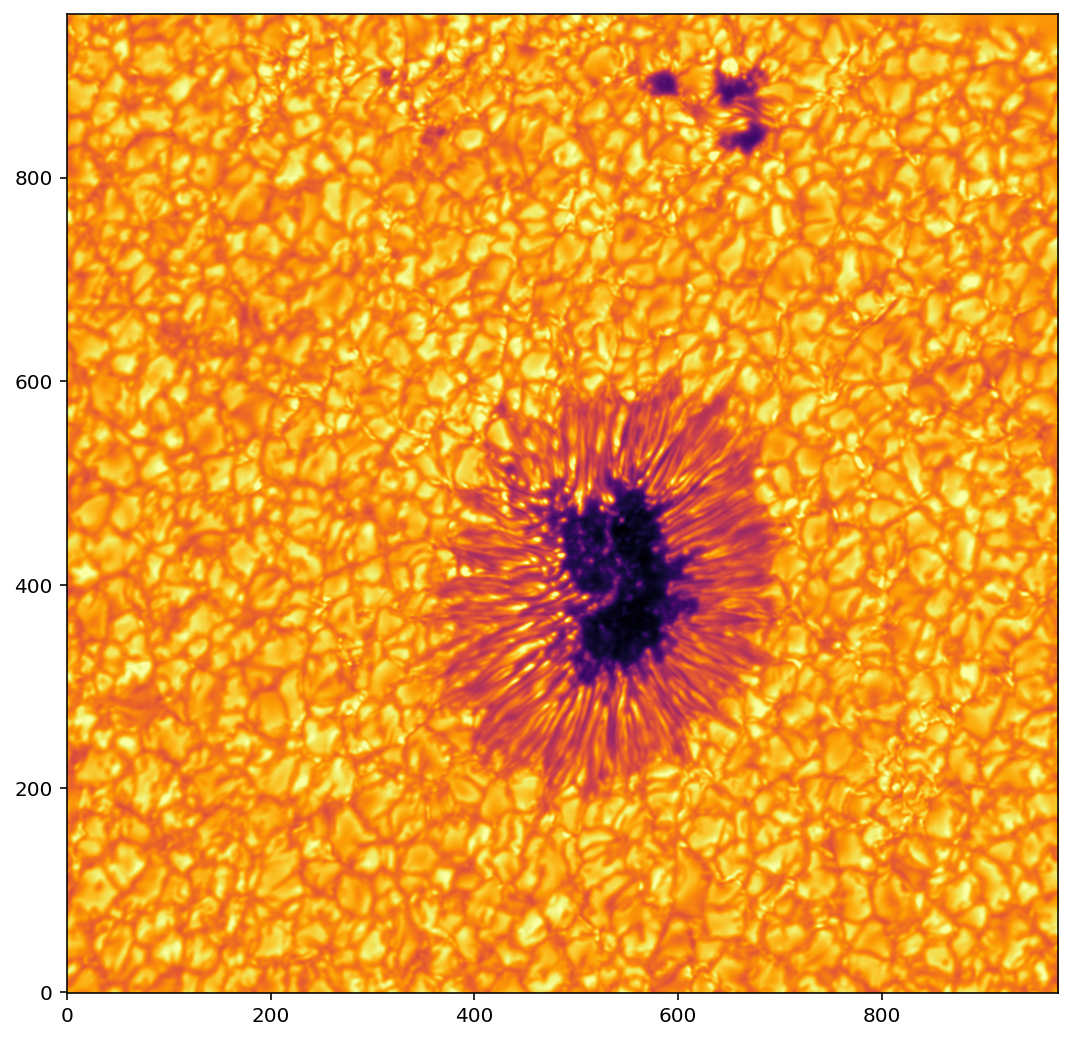

In [6]:
fig, ax = plt.subplots(figsize=(11,9))
ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno');

Plotting the spectra of a single pixel.

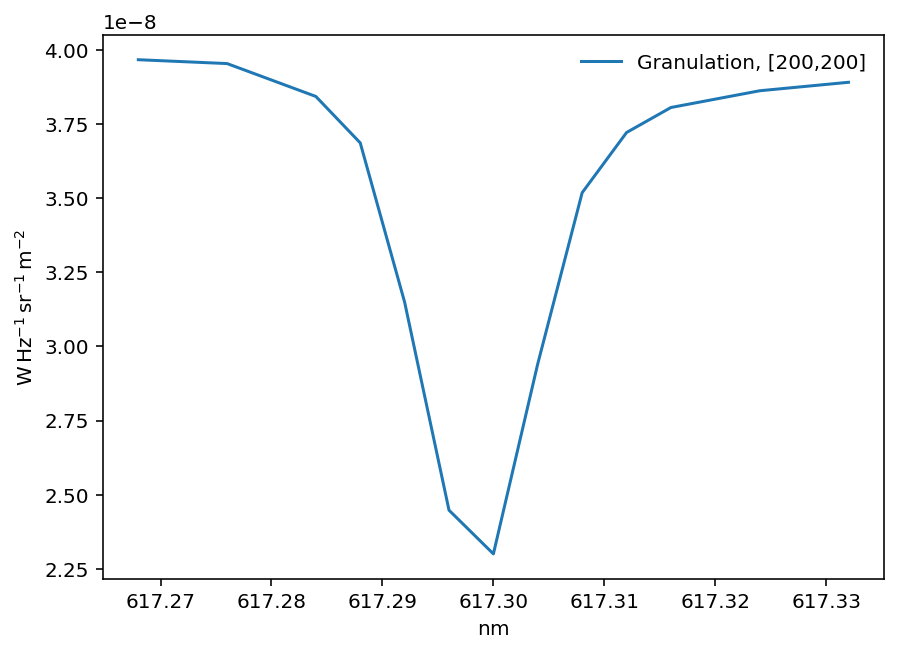

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
wavelength = data['wavelength']
ax.plot(wavelength, data['intensity'][:, 200, 200], label='Granulation, [200,200]')
#ax.plot(wavelength, data['intensity'][:, 200, 240], label='other')

#ax.plot(wavelength, data['intensity'][:, 400, 550], label='Umbra')
ax.legend();

*Using spectral velocities and brightness temperatures, what can you tell about the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us?*


### Brightness temperature

Starting with the brightness temperature. Zooming on in the granulation plot to find the perfect granule. 





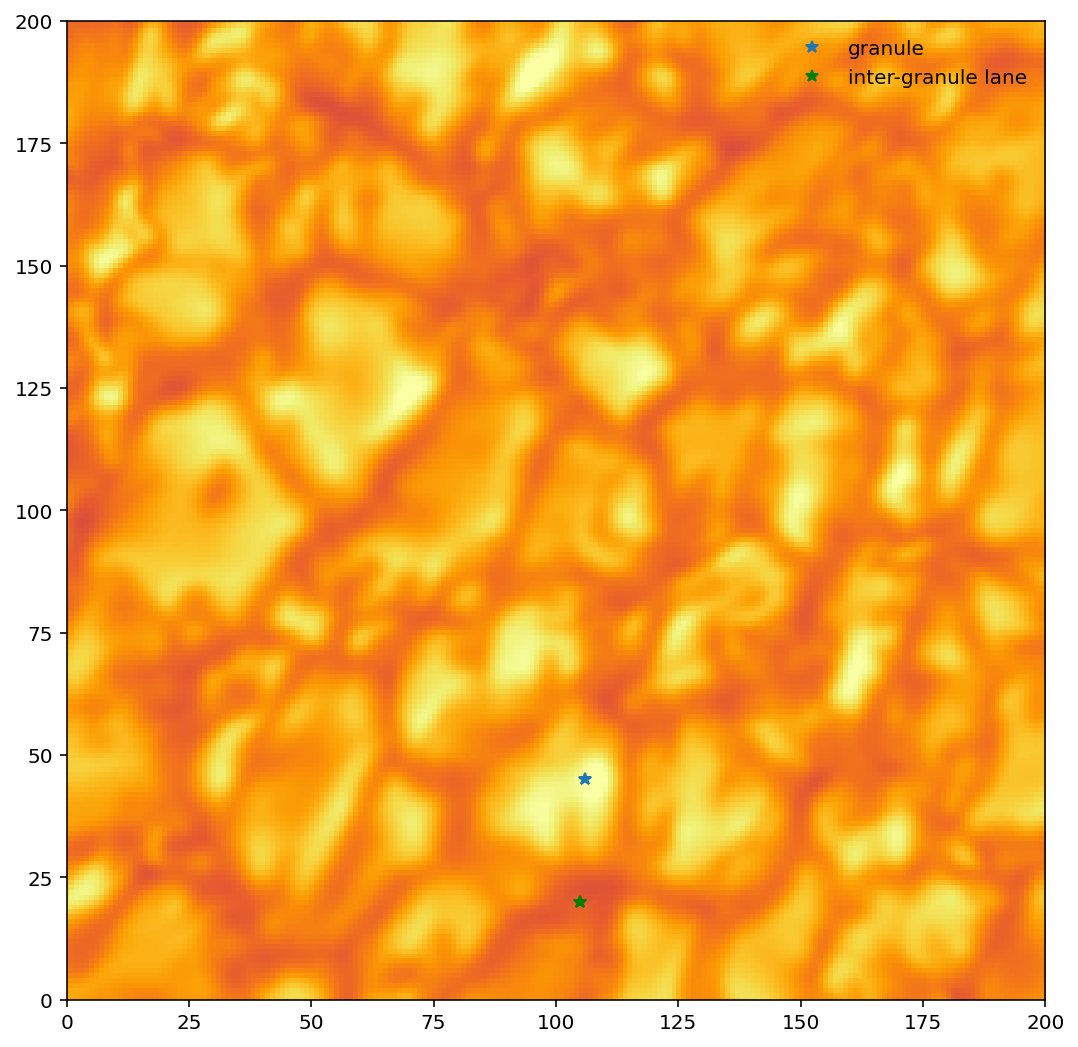

In [8]:
fig, ax = plt.subplots(figsize=(11,9))
ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno');
ax.set_xlim([0,200])
ax.set_ylim([0,200])
ax.plot([106, 106], [45,45], "*", label="granule")
ax.plot([105, 105], [20,20], "g*", label="inter-granule lane")
ax.legend()

First, we see a clear difference between the spectra of the granule and the inter-granule lane. The continuums are at different intensities, and their lowest points are at different wavelengths. From this we can predict to find a difference in brightness temperature and a Doppler shift in the velocity. Let us look at the intensity in the continuum and calculate the corresponding brightness temperature. 

In [9]:
cont_gran = data['intensity'][0, 45, 106]
cont_lane = data['intensity'][0, 20, 105]
cont_test = data['intensity'][0, 208, 231]

print("Intensity granule continuum:", cont_gran)
print("Intensity granule lane continuum:", cont_lane)

Intensity granule continuum: 4.584241608540651e-08 W / (Hz m2 sr)
Intensity granule lane continuum: 3.116997859820003e-08 W / (Hz m2 sr)


We can connect the observed intensity $I_{\lambda}^{\rm obs}$ and the brightness temperature from the following relation: 

\begin{align}
     B_{\lambda}(T_b) = I_{\lambda}^{\rm obs},
\end{align}

where $B_{\lambda}(T_b)$ is the Planck function for wavelength. Since our data set with intensity has the units $\rm [W /(Hz~m^2 ~sr)]$, we have to use the Planck function for frequency, $B_{\nu}$, in order to calculate the brightness temperature. The Planck function $B_{\nu}$ can then be expressed by: 

\begin{align}
    B_{\nu} = \frac{2h\nu^3}{c^2} \frac{1}{\exp\left( \frac{h\nu}{k_B T}\right) - 1}
\end{align}

By rewriting $B_{\nu}$, we can express the brightness temperature $T_b$ as: 

\begin{align}
    T_b = \frac{h\nu}{k_B\ln \left( 1 + \frac{2h\nu^3}{I_{\nu}^{\rm obs}c^2} \right)}
\end{align}

In [10]:
def T_b(nu, I_obs): 
    I_obs = (I_obs*units.sr).to("J/s m2 Hz")
    return (h*nu)/(kB*np.log(1 + (2*h*nu**3)/(I_obs*c**2)))

Temp granule 6414.814551459167 K
Temp granule lane 5811.434699362487 K


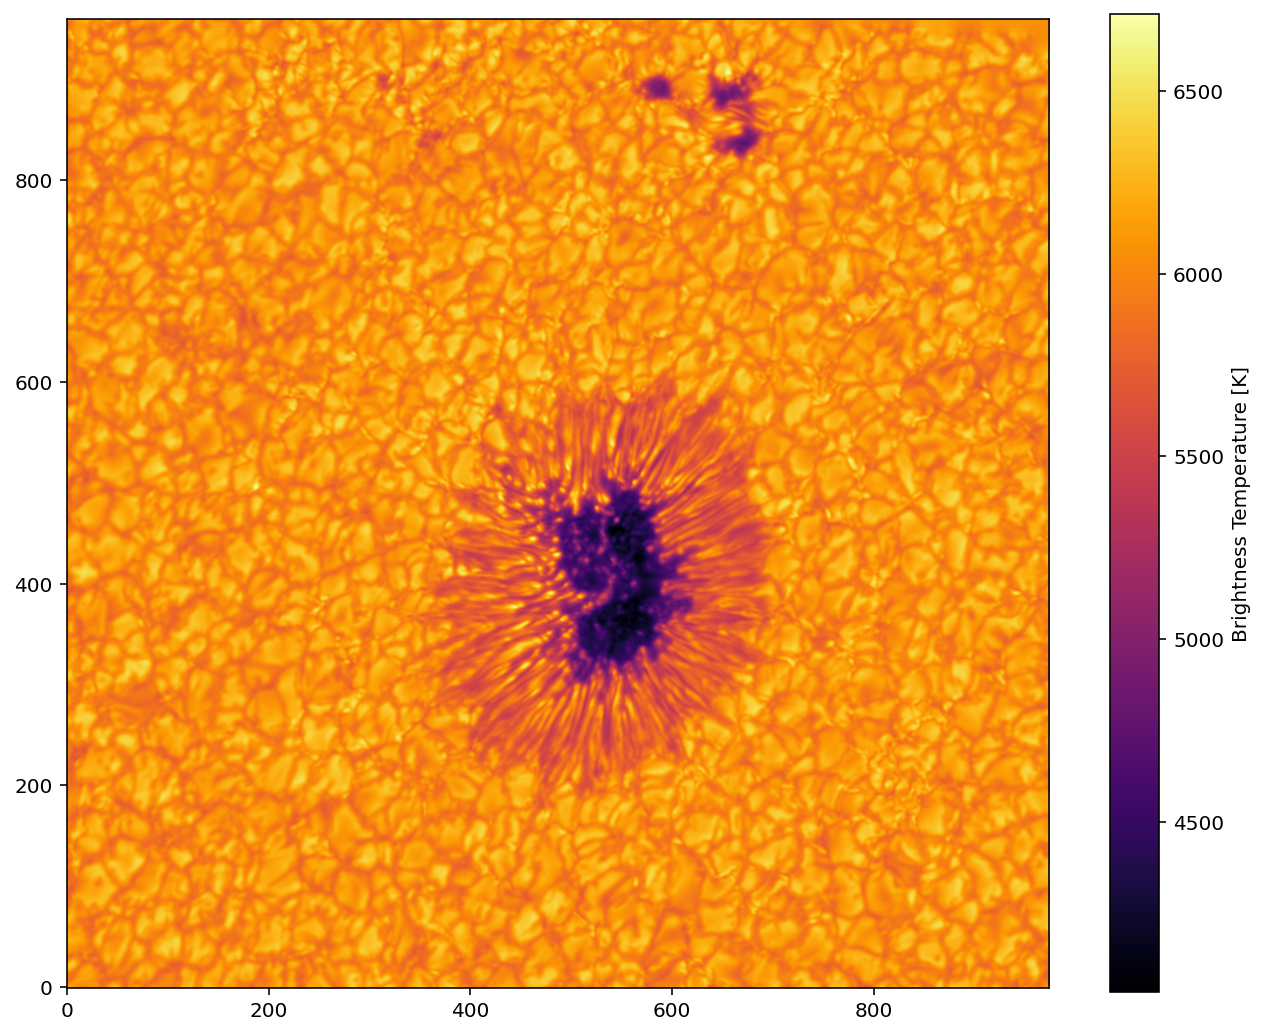

In [25]:
lam_cont = wavelength[0].to("m")#value*10**(-9)
nu_cont = c/lam_cont

print("Temp granule", T_b(nu_cont, cont_gran))
print("Temp granule lane", T_b(nu_cont, cont_lane))

#Plotting the Brightness temperature

data['brightness_temperature'] = (h*nu_cont)/(kB*np.log(1 + (2*h*nu_cont**3)/(data['intensity']*units.sr*c**2)))

fig, ax = plt.subplots(figsize=(11,9))
im = ax.imshow(data['brightness_temperature'][0].value, cmap='inferno');
cbar = fig.colorbar(im)
cbar.set_label(r'Brightness Temperature [K]')

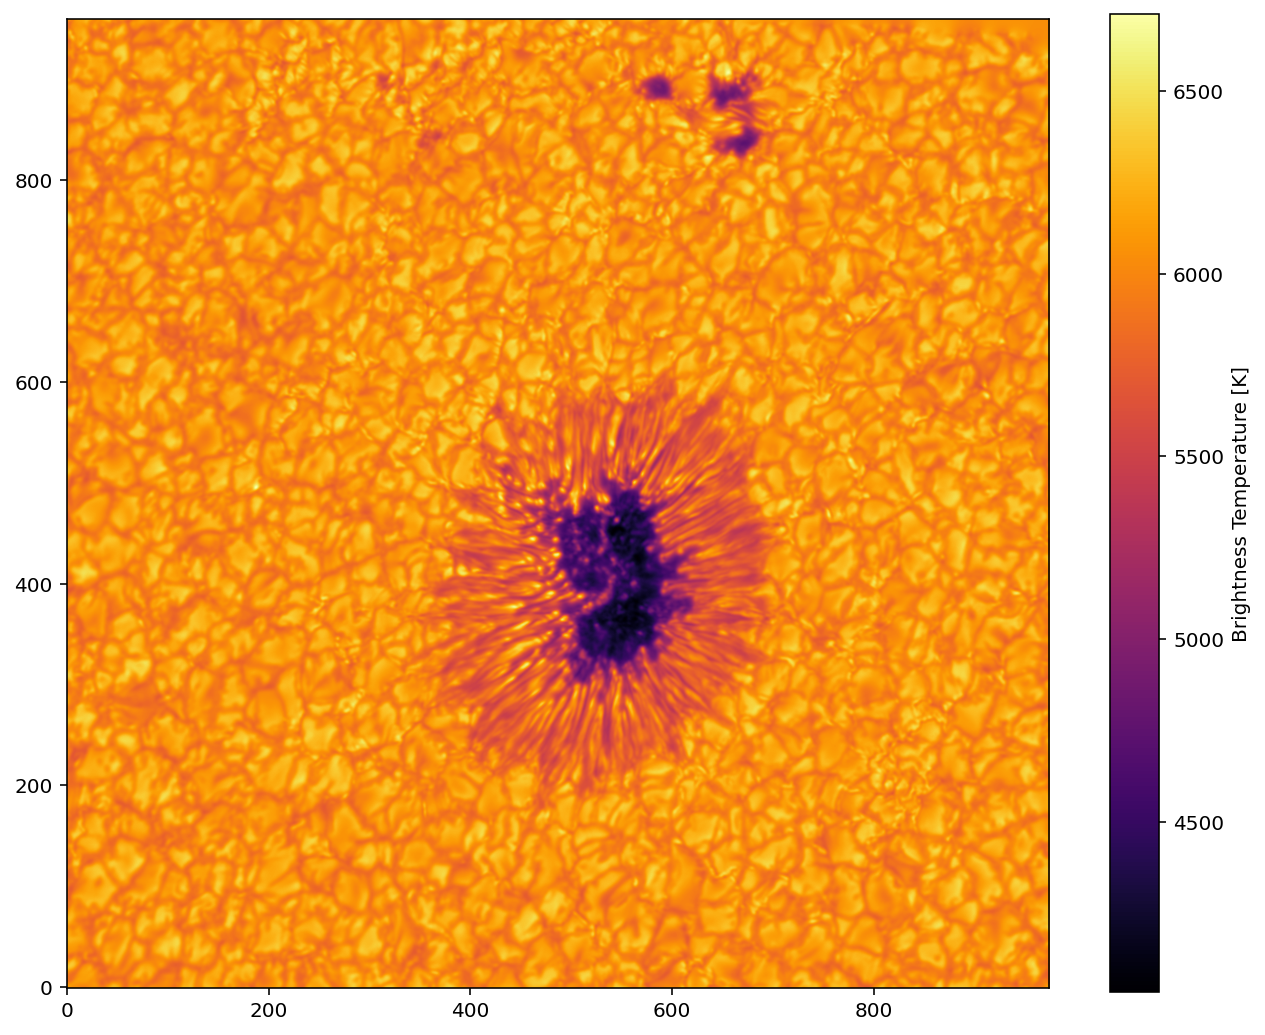

In [34]:
#Code from fellow sunspot poioneer :)

k, h, c = const.k_B, const.h, const.c

nu = data['wavelength'].to(units.Hz, equivalencies=units.spectral())
intensity = data['intensity']

#There was a parenthesis missing to get the logarithm in the nominator
T_b = (h*nu/(k * np.log(((2*h*nu**3)/(c**2 * intensity.T*units.sr)) + 1))).decompose()

data['brightness_temperature'] = T_b.T

fig, ax = plt.subplots(figsize=(11,9))
im = ax.imshow(data['brightness_temperature'][0].value, cmap='inferno');
cbar = fig.colorbar(im)
cbar.set_label(r'Brightness Temperature [K]')



Now i think we get the same plot for the Brightness temperature.

### Gaussian fitting

Let us now look at the velocity. Plotting the spectra in the two pixels just to visualize, and then to compare their lowest point to the calculated first moment.

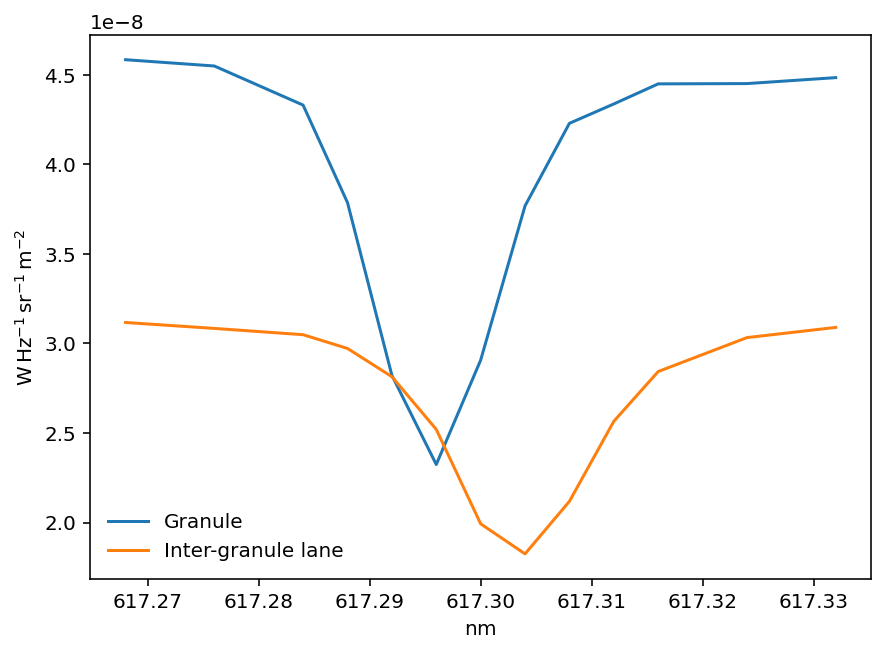

In [37]:
fig, ax = plt.subplots(figsize=(7, 5))
wavelength = data['wavelength']
ax.plot(wavelength, data['intensity'][:, 45, 106], label='Granule')
ax.plot(wavelength, data['intensity'][:, 20, 105], label='Inter-granule lane')
ax.legend()

In [38]:
#No fitting, only looking at the data to compare
lam_dip_gran = wavelength[np.argmin(data['intensity'][:, 45, 106])]
lam_dip_lane = wavelength[np.argmin(data['intensity'][:, 20, 105])]
print(lam_dip_gran)
print(lam_dip_lane)

print(data['intensity'][:, 45, 106].value.max())


617.296 nm
617.304 nm
4.5842416e-08


#### Fitting the spectra using moments

In [47]:
inverse_I = data['intensity'][:-1] #The [:-1] made the gaussian peaks a bit better. Not necessary to make the plot
inverse_I = inverse_I[0] - inverse_I
print(np.shape(inverse_I[:,45,106]))

w_central = 617.30*units.nm #central wavelength in the data set
w = data['wavelength'][:-1]

print("dx", w[5]-w[4], w[4]-w[3], w[3]-w[2]) #checking that the wavelengths are evenly spaced

#Computing the first moment
moment1 = np.trapz(w[:, np.newaxis, np.newaxis]*inverse_I, w, axis=0)/(np.trapz(inverse_I, w, axis=0))

#printing the first moment for the granule and the granule lane
print(moment1[45, 106])
print(moment1[20, 105])

#computing the second moment, and printing for the granule and the granule lane
moment2 = np.trapz((w[:, np.newaxis, np.newaxis] - moment1)**2 * inverse_I, w, axis=0)/(np.trapz(inverse_I, w, axis=0))
print(moment2[45, 106])
print(moment2[20, 105])

(12,)
dx 0.004000000000019099 nm 0.004000000000019099 nm 0.004000000000019099 nm
617.2971179745516 nm
617.3032794125903 nm
6.089199751372062e-05 nm2
6.534239274008289e-05 nm2


[4.84267227e-02 1.31298066e+00 1.24442914e+01 2.58317046e+01
 4.12306905e+01 5.06025961e+01 4.77539870e+01 3.46522249e+01
 1.93346921e+01 8.29522259e+00 2.73655056e+00 1.35396764e-01]
617.296 nm


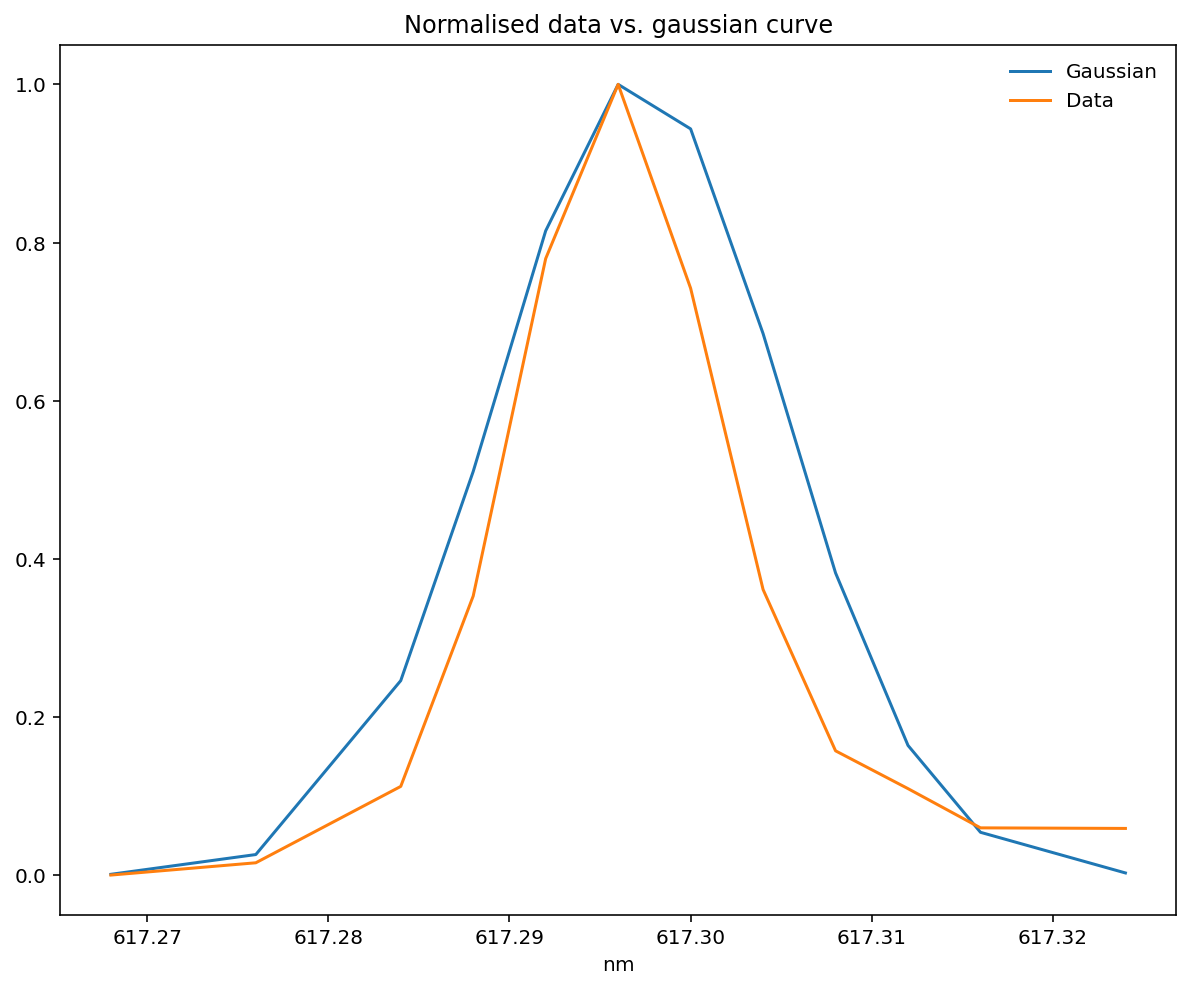

In [48]:
#Gaussian function, using the first and second moments
def gaussian(x, mu, sigma_sq): 
    return 1/(np.sqrt(sigma_sq)*np.sqrt(2*np.pi))*np.exp(-0.5*(x-mu)**2/sigma_sq)

#print(gaussian(w, moment1[45, 106], moment2[45, 106]).value)

index = np.argmax(gaussian(w, moment1[45, 106], moment2[45, 106]))
print(w[index])

plt.plot(w, gaussian(w, moment1[45, 106], moment2[45, 106]).value/np.max(gaussian(w, moment1[45, 106], moment2[45, 106]).value), label="Gaussian")
plt.plot(w, inverse_I[:,45, 106].value/np.max(inverse_I[:,45, 106].value), label="Data")
plt.legend()
plt.title("Normalised data vs. gaussian curve, granule")
plt.show()



#### Velocity in the line of sight


In [46]:
v = c*(w_central-moment1[45,106])/w_central
print(v)

1399.658987813778 m / s


### Notes from group session

Explain what is what in the sunspot image. Granules, lanes etc. 

Start with temperature. PLanck function is equal to the intensity. 

We can get the microscopic velocity. Bulk motionin the plasma will shift the wavelength. Calculate the shift in wavelength and from there the Doppler velocity. 

Zeeman effect. Infer the magnetic field strength of the sunspot. 

Figure out the difference between the sunpsot and the surroundings/pores. 

Line width: use for the velocity. 


**Data set:**
One pixel is 48 km on the solar surface. Stored in a fits file. 

Almost no circular polarization in the umbra. 
Explain the line is broad in the umbra. SOmething to do with the magnetic field. 

You can also fit Gaussian profiles. Save the file if so. 





### Structure
Introduction: do not need to be long 

Method: temperature. How you calculate stuff. 

Result: show

Discussion and conclusion. What is difference between stuff. You can alsi include this in the result and just discuss it there. 

Conclusion: seperate if we merge the result and discussion. 


#### Other stuff
moment: numpy.trapz. 
Diverging colormap. sequencial. 

cmap: coolwarm
You can set min and max value. Makes it easier to see. 


